In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import (train_test_split,StratifiedKFold,cross_val_predict,GridSearchCV,cross_validate)
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import (RandomForestClassifier,VotingClassifier,StackingClassifier,GradientBoostingClassifier)
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,confusion_matrix,classification_report, roc_curve, auc)
import matplotlib.pyplot as plt

In [2]:
#load the csv file.
df = pd.read_csv("Mental_Stress_and_Coping_Mechanisms_processed.csv")


dummy_cols = [
    "Stress Level Category_Low",
    "Stress Level Category_Medium",
    "Stress Level Category_High"
]
df['Stress Level Category'] = (
    df[dummy_cols]
      .idxmax(axis=1)  # picks the dummy with a 1
      .str.replace("Stress Level Category_", "", regex=False)
)

cols_to_drop = [
    "Mental Stress Level",
    *dummy_cols,
    "Stress Coping Mechanisms",
    "Unnamed: 0"
]
df = df.drop(columns=cols_to_drop, errors="ignore")

# Combine less common gender categories into a single 'Other' column
df['Gender_Other'] = (df[['Gender_Agender','Gender_Bigender','Gender_Genderfluid']].sum(axis=1).clip(upper=1))

# Convert daily social media usage (hours per day) to weekly total
df['Social_Media_Usage_per_week'] = df['Social Media Usage (Hours per day)'] * 7

#features selected after PCA
selected_features = [
    'Age','Academic Performance (GPA)','Study Hours Per Week',
    'Social_Media_Usage_per_week','Sleep Duration (Hours per night)',
    'Physical Exercise (Hours per week)','Family Support','Financial Stress',
    'Peer Pressure','Relationship Stress','Counseling Attendance','Diet Quality',
    'Cognitive Distortions','Family Mental Health History','Medical Condition',
    'Substance Use','Gender_Female','Gender_Male','Gender_Other'
]
X = df[selected_features]
y = df['Stress Level Category']

Q1, Q3 = X['Study Hours Per Week'].quantile([0.25,0.75])
IQR = Q3 - Q1
mask = X['Study Hours Per Week'].between(Q1-1.5*IQR, Q3+1.5*IQR)
X, y = X[mask], y[mask]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

train_df = X_train.copy()
train_df['Stress Level Category'] = y_train
test_df  = X_test.copy()
test_df ['Stress Level Category'] = y_test

train_df.to_csv("train_data.csv", index=False)
test_df .to_csv("test_data.csv",  index=False)

Accuracy (train, OOF): 0.4988
Confusion Matrix:
[[767 280 532]
 [298 791 490]
 [377 397 805]]
Precision (weighted): 0.5038
Recall    (weighted): 0.4988
F1-score  (weighted): 0.4999
ROC AUC   (weighted OVR): 0.6717

Classification Report:
              precision    recall  f1-score   support

         Low       0.53      0.49      0.51      1579
      Medium       0.54      0.50      0.52      1579
        High       0.44      0.51      0.47      1579

    accuracy                           0.50      4737
   macro avg       0.50      0.50      0.50      4737
weighted avg       0.50      0.50      0.50      4737



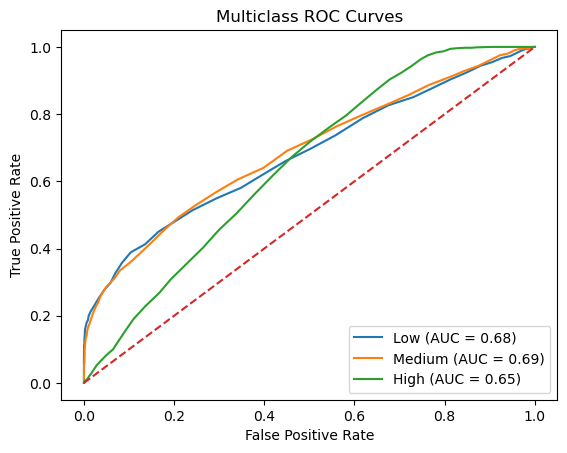

In [2]:
#RandomForest
# Load and prepare data
train_df = pd.read_csv("train_data.csv")
X = train_df.drop(columns=["Stress Level Category"])
y = train_df["Stress Level Category"].map({'Low': 0, 'Medium': 1, 'High': 2}).values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Balance classes with SMOTE
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_scaled, y)

# Out-of-fold predictions via stratified 5-fold CV
model = RandomForestClassifier(random_state=42)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred = cross_val_predict(model, X_resampled, y_resampled, cv=kf)
y_proba = cross_val_predict(model, X_resampled, y_resampled, cv=kf, method='predict_proba')

# Compute standard metrics
acc   = accuracy_score(y_resampled, y_pred)
cm    = confusion_matrix(y_resampled, y_pred)
prec  = precision_score(y_resampled, y_pred, average='weighted')
rec   = recall_score(y_resampled, y_pred, average='weighted')
f1    = f1_score(y_resampled, y_pred, average='weighted')

# Compute multiclass ROC AUC (one-vs-rest, weighted)
roc_auc = roc_auc_score(y_resampled, y_proba, multi_class='ovr', average='weighted')

# Display core results
print(f"Accuracy (train, OOF): {acc:.4f}")
print("Confusion Matrix:")
print(cm)
print(f"Precision (weighted): {prec:.4f}")
print(f"Recall    (weighted): {rec:.4f}")
print(f"F1-score  (weighted): {f1:.4f}")
print(f"ROC AUC   (weighted OVR): {roc_auc:.4f}\n")
print("Classification Report:")
print(classification_report(
    y_resampled,
    y_pred,
    target_names=['Low', 'Medium', 'High']
))

# Plot ROC curves for each class
fpr, tpr, roc_auc_dict = {}, {}, {}
labels = ['Low', 'Medium', 'High']
for i, label in enumerate(labels):
    fpr[i], tpr[i], _    = roc_curve(y_resampled == i, y_proba[:, i])
    roc_auc_dict[i]      = auc(fpr[i], tpr[i])

plt.figure()
for i, label in enumerate(labels):
    plt.plot(fpr[i], tpr[i], label=f"{label} (AUC = {roc_auc_dict[i]:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curves")
plt.legend(loc="lower right")
plt.show()

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best RF params:    {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best CV accuracy: 0.5136 

Accuracy (train, OOF):   0.5062
Confusion Matrix:
[[751 269 559]
 [263 775 541]
 [349 358 872]] 

Precision (weighted):    0.5153
Recall    (weighted):    0.5062
F1-score  (weighted):    0.5072
ROC AUC   (weighted OVR):0.6823

Classification Report:
              precision    recall  f1-score   support

         Low       0.55      0.48      0.51      1579
      Medium       0.55      0.49      0.52      1579
        High       0.44      0.55      0.49      1579

    accuracy                           0.51      4737
   macro avg       0.52      0.51      0.51      4737
weighted avg       0.52      0.51      0.51      4737



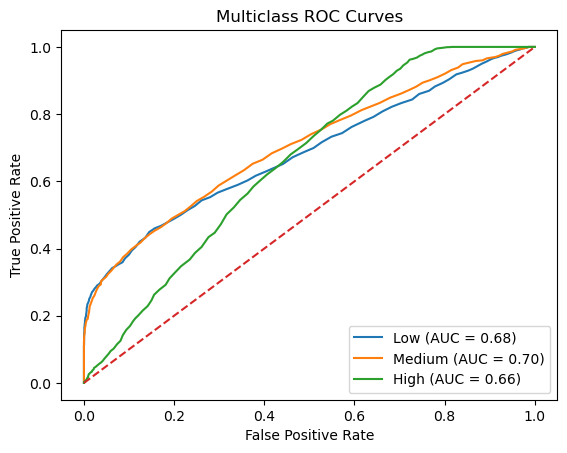

In [3]:
# Hyperparameter tuning via GridSearchCV
param_grid = {
    'n_estimators':      [100, 200, 300],
    'max_depth':         [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf':  [1, 2, 4]
}
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_resampled, y_resampled)
best_model  = grid_search.best_estimator_
print("Best RF params:   ", grid_search.best_params_)
print("Best CV accuracy:", round(grid_search.best_score_, 4), "\n")

# Out-of-fold predictions
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred  = cross_val_predict(best_model, X_resampled, y_resampled, cv=kf)
y_proba = cross_val_predict(best_model, X_resampled, y_resampled, cv=kf, method='predict_proba')

# Compute standard metrics
acc   = accuracy_score(y_resampled, y_pred)
cm    = confusion_matrix(y_resampled, y_pred)
prec  = precision_score(y_resampled, y_pred, average='weighted')
rec   = recall_score(y_resampled, y_pred, average='weighted')
f1    = f1_score(y_resampled, y_pred, average='weighted')

# Compute multiclass ROC AUC (one-vs-rest, weighted)
roc_auc = roc_auc_score(y_resampled, y_proba, multi_class='ovr', average='weighted')

# Print metrics
print(f"Accuracy (train, OOF):   {acc:.4f}")
print("Confusion Matrix:")
print(cm, "\n")
print(f"Precision (weighted):    {prec:.4f}")
print(f"Recall    (weighted):    {rec:.4f}")
print(f"F1-score  (weighted):    {f1:.4f}")
print(f"ROC AUC   (weighted OVR):{roc_auc:.4f}\n")

print("Classification Report:")
print(classification_report(
    y_resampled,
    y_pred,
    target_names=['Low', 'Medium', 'High']
))

# Plot ROC curves for each class
fpr = {}
tpr = {}
roc_auc_dict = {}
labels = ['Low', 'Medium', 'High']

for i, label in enumerate(labels):
    fpr[i], tpr[i], _ = roc_curve(y_resampled == i, y_proba[:, i])
    roc_auc_dict[i] = auc(fpr[i], tpr[i])

plt.figure()
for i, label in enumerate(labels):
    plt.plot(fpr[i], tpr[i], label=f"{label} (AUC = {roc_auc_dict[i]:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curves")
plt.legend(loc="lower right")
plt.show()

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best SVM parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best CV accuracy   : 0.5987 

Accuracy (train, OOF):   0.5582
Confusion Matrix:
[[ 529    3 1047]
 [   2  538 1039]
 [   2    0 1577]] 

Precision (weighted):    0.8058
Recall    (weighted):    0.5582
F1-score  (weighted):    0.5367
ROC AUC   (weighted OVR):0.7422

Classification Report:
              precision    recall  f1-score   support

         Low       0.99      0.34      0.50      1579
      Medium       0.99      0.34      0.51      1579
        High       0.43      1.00      0.60      1579

    accuracy                           0.56      4737
   macro avg       0.81      0.56      0.54      4737
weighted avg       0.81      0.56      0.54      4737



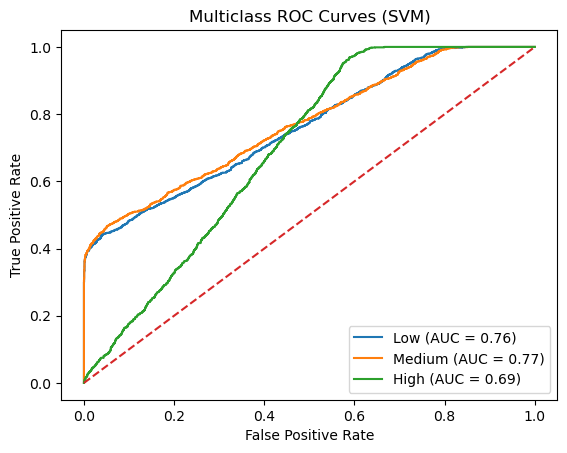

In [6]:
#SVM with the hyperparameters
train_df = pd.read_csv("train_data.csv")
X = train_df.drop(columns=["Stress Level Category"])
y = train_df["Stress Level Category"].map({'Low': 0, 'Medium': 1, 'High': 2}).values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Balance classes with SMOTE
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_scaled, y)

# Hyperparameter tuning via GridSearchCV
svm_param_grid = {
    'C':     [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.1, 1],
    'kernel':['rbf']
}
svm_base = SVC(
    class_weight='balanced',
    probability=True,
    random_state=42
)
svm_grid_search = GridSearchCV(
    estimator=svm_base,
    param_grid=svm_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
svm_grid_search.fit(X_resampled, y_resampled)

svm_best       = svm_grid_search.best_estimator_
svm_best_params= svm_grid_search.best_params_
svm_best_score = svm_grid_search.best_score_

print("Best SVM parameters:", svm_best_params)
print("Best CV accuracy   :", round(svm_best_score, 4), "\n")

kf        = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred    = cross_val_predict(svm_best, X_resampled, y_resampled, cv=kf)
y_proba   = cross_val_predict(svm_best, X_resampled, y_resampled, cv=kf, method='predict_proba')

# Compute metrics
acc   = accuracy_score(y_resampled, y_pred)
cm    = confusion_matrix(y_resampled, y_pred)
prec  = precision_score(y_resampled, y_pred, average='weighted')
rec   = recall_score(y_resampled, y_pred, average='weighted')
f1    = f1_score(y_resampled, y_pred, average='weighted')
roc_auc = roc_auc_score(y_resampled, y_proba, multi_class='ovr', average='weighted')

print(f"Accuracy (train, OOF):   {acc:.4f}")
print("Confusion Matrix:")
print(cm, "\n")
print(f"Precision (weighted):    {prec:.4f}")
print(f"Recall    (weighted):    {rec:.4f}")
print(f"F1-score  (weighted):    {f1:.4f}")
print(f"ROC AUC   (weighted OVR):{roc_auc:.4f}\n")
print("Classification Report:")
print(classification_report(
    y_resampled,
    y_pred,
    target_names=['Low', 'Medium', 'High']
))

fpr = {}
tpr = {}
roc_auc_dict = {}
labels = ['Low', 'Medium', 'High']

for i, label in enumerate(labels):
    fpr[i], tpr[i], _ = roc_curve(y_resampled == i, y_proba[:, i])
    roc_auc_dict[i]   = auc(fpr[i], tpr[i])

plt.figure()
for i, label in enumerate(labels):
    plt.plot(fpr[i], tpr[i], label=f"{label} (AUC = {roc_auc_dict[i]:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curves (SVM)")
plt.legend(loc="lower right")
plt.show()

In [8]:
#XGBoost model
le = LabelEncoder()
y_encoded = le.fit_transform(y_resampled)

xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_cv_scores = cross_val_score(
    xgb_model,
    X_resampled,
    y_encoded,
    cv=5,
    scoring='accuracy'
)
print("XGBoost Mean CV Accuracy:", np.mean(xgb_cv_scores).round(4))
print("XGBoost CV Scores:", xgb_cv_scores)

C:\Users\91816\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [17:22:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\91816\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [17:22:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\91816\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [17:22:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg,

XGBoost Mean CV Accuracy: 0.4524
XGBoost CV Scores: [0.38924051 0.39029536 0.38225977 0.43611404 0.66420275]


In [11]:
#XGBoost model with hyperparameter
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_resampled)

xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
param_grid = {
    'n_estimators':    [100, 200],
    'max_depth':       [3, 5],
    'learning_rate':   [0.1],
    'subsample':       [1.0],
    'colsample_bytree':[0.8]
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_resampled, y_train_encoded)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


C:\Users\91816\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\91816\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [17:24:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Best Cross-Validation Accuracy: 0.42708664715134176


In [15]:
#Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gb_cv_scores = cross_val_score(gb_model, X_resampled, y_resampled, cv=kf, scoring='accuracy')
gb_mean_accuracy = np.mean(gb_cv_scores)
gb_std_accuracy = np.std(gb_cv_scores)
gb_mean_accuracy, gb_std_accuracy, gb_cv_scores

(0.4089135578041249,
 0.013561004866717151,
 array([0.40189873, 0.39240506, 0.41182682, 0.40549102, 0.43294615]))

In [16]:
gb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}

gb_grid_search = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_grid=gb_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

gb_grid_search.fit(X_resampled, y_resampled)

# Extract best parameters and score
gb_best_params = gb_grid_search.best_params_
gb_best_score = gb_grid_search.best_score_

gb_best_params, gb_best_score

Fitting 5 folds for each of 8 candidates, totalling 40 fits


({'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200},
 0.43152326467325197)

In [17]:
#LightGradientBoosting Model
from lightgbm import LGBMClassifier
lgb_default_model = LGBMClassifier(random_state=42)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lgb_default_scores = cross_val_score(lgb_default_model, X_resampled, y_resampled, cv=kf, scoring='accuracy')
lgb_default_mean = np.mean(lgb_default_scores)
lgb_default_std = np.std(lgb_default_scores)
lgb_default_mean, lgb_default_std, lgb_default_scores

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3427
[LightGBM] [Info] Number of data points in the train set: 3789, number of used features: 19
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3433
[LightGBM] [Info] Number of data points in the train set: 3789, number of used features: 19
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start tr

(0.44332513511466376,
 0.012837720180596564,
 array([0.42510549, 0.43037975, 0.45406547, 0.45406547, 0.4530095 ]))

In [18]:
#LightGradientBoosting Model with hyperparameters
lgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 7],
    'num_leaves': [15, 31],
    'min_child_samples': [10, 20]
}

# Setup GridSearchCV
lgb_grid = GridSearchCV(
    estimator=LGBMClassifier(random_state=42),
    param_grid=lgb_param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

# Fit on training data
lgb_grid.fit(X_resampled, y_resampled)

# Best parameters and score
lgb_best_params = lgb_grid.best_params_
lgb_best_score = lgb_grid.best_score_

print("Best LightGBM Parameters:", lgb_best_params)
print("Best CV Accuracy:", round(lgb_best_score, 4))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3454
[LightGBM] [Info] Number of data points in the train set: 4737, number of used features: 19
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

In [19]:
#Catboost model
cat_default_model = CatBoostClassifier(verbose=0, random_state=42)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cat_default_scores = cross_val_score(cat_default_model, X_resampled, y_resampled, cv=kf, scoring='accuracy')
cat_default_mean = np.mean(cat_default_scores)
cat_default_std = np.std(cat_default_scores)
cat_default_mean, cat_default_std, cat_default_scores

(0.48512023311456565,
 0.006940867121298876,
 array([0.47362869, 0.48206751, 0.49313622, 0.49102429, 0.48574446]))

In [21]:
# Define the parameter grid for CatBoost
cat_param_grid = {
    'iterations': [100, 200],
    'learning_rate': [0.05, 0.1],
    'depth': [3, 5, 7]
}

# Setup GridSearchCV
cat_grid_search = GridSearchCV(
    estimator=CatBoostClassifier(verbose=0, random_state=42),
    param_grid=cat_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
cat_grid_search.fit(X_resampled, y_resampled)
cat_best_params = cat_grid_search.best_params_
cat_best_score = cat_grid_search.best_score_

cat_best_params, cat_best_score

Fitting 5 folds for each of 12 candidates, totalling 60 fits


({'depth': 7, 'iterations': 200, 'learning_rate': 0.1}, 0.4682544032008697)

In [25]:
#Ensemble method with RandomForest best parameters and SVM best parameters
rf_best = RandomForestClassifier(
    max_depth=None,
    n_estimators=300,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)
svm_best = SVC(
    kernel='rbf',
    C=10,
    gamma=1,
    probability=True,    
    random_state=42
)
voting_model = VotingClassifier(
    estimators=[
        ('rf',  rf_best),
        ('svm', svm_best)
    ],
    voting='soft'
)

# define CV and scoring metrics
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'accuracy':       'accuracy',
    'precision':      'precision_weighted',
    'recall':         'recall_weighted',
    'f1':             'f1_weighted',
    'roc_auc_ovr':    'roc_auc_ovr'        # multiclass One-vs-Rest ROC-AUC
}

# run CV
cv_results = cross_validate(
    voting_model,
    X_resampled,
    y_resampled,
    cv=kf,
    scoring=scoring,
    return_train_score=False
)

# aggregate and print
print("Voting Ensemble (5-fold CV) metrics:\n")
for metric in scoring:
    scores = cv_results[f'test_{metric}']
    print(f" • {metric.title():<10}: mean={np.mean(scores):.4f}  std={np.std(scores):.4f}")
    
# if you also want the individual fold scores:
print("\nFold-wise scores:")
for metric in scoring:
    print(f" {metric.title():<10}:", np.round(cv_results[f'test_{metric}'], 4))

Voting Ensemble (5-fold CV) metrics:

 • Accuracy  : mean=0.5846  std=0.0161
 • Precision : mean=0.7882  std=0.0076
 • Recall    : mean=0.5846  std=0.0161
 • F1        : mean=0.5722  std=0.0193
 • Roc_Auc_Ovr: mean=0.7461  std=0.0185

Fold-wise scores:
 Accuracy  : [0.5665 0.5665 0.585  0.6019 0.603 ]
 Precision : [0.7889 0.7766 0.7947 0.7832 0.7976]
 Recall    : [0.5665 0.5665 0.585  0.6019 0.603 ]
 F1        : [0.5506 0.5506 0.572  0.5939 0.5937]
 Roc_Auc_Ovr: [0.7181 0.7307 0.7589 0.7564 0.7665]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib, json

# A) Reload the split data you wrote out earlier
train = pd.read_csv("train_data.csv")
test  = pd.read_csv("test_data.csv")

# B) Extract X/y and encode target into 0/1/2
feature_columns = [   # must match exactly what you persisted in feature_columns.json
    'Age','Academic Performance (GPA)','Study Hours Per Week',
    'Social_Media_Usage_per_week','Sleep Duration (Hours per night)',
    'Physical Exercise (Hours per week)','Family Support','Financial Stress',
    'Peer Pressure','Relationship Stress','Counseling Attendance','Diet Quality',
    'Cognitive Distortions','Family Mental Health History','Medical Condition',
    'Substance Use','Gender_Female','Gender_Male','Gender_Other','Stress_Ratio'
]
label_map = {'Low':0, 'Medium':1, 'High':2}

X_train = train[feature_columns].values
y_train = train["Stress Level Category"].map(label_map).values

X_test  = test[feature_columns].values
y_test  = test["Stress Level Category"].map(label_map).values

# C) Scale features
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# D) Balance with SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_s, y_train)

# E) Train the tuned RandomForest (your best hyperparameters here)
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced',
    random_state=42
)
#   Evaluate via 5-fold CV on the resampled train
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf, X_train_res, y_train_res, cv=kf, scoring='accuracy')
print(f"RF Mean CV Accuracy: {cv_scores.mean():.4f}")
print(f"Fold-wise: {np.round(cv_scores,4)}")

#   Fit on the entire resampled training set
rf.fit(X_train_res, y_train_res)

# F) Evaluate on your held-out test set
y_pred_test = rf.predict(X_test_s)
print("\n=== Hold-out Test Classification ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print(classification_report(y_test, y_pred_test, target_names=['Low','Medium','High']))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))

# G) Persist all inference artifacts
joblib.dump(scaler,    "scaler.joblib")
joblib.dump(rf,        "rf_model.joblib")
with open("label_map.json","w") as f:
    json.dump(label_map, f)
with open("feature_columns.json","w") as f:
    json.dump(feature_columns, f)

print("Saved scaler.joblib, rf_model.joblib, label_map.json, feature_columns.json")

In [ ]:
# … your existing imports …
from sklearn.impute import SimpleImputer
import joblib
import json


# Persist the StandardScaler
joblib.dump(scaler,     "scaler.joblib")

# Persist the median‐imputer
joblib.dump(imputer,    "imputer.joblib")

# Persist the tuned SVM
joblib.dump(rf, "rf_model.joblib")

# Persist the label‐map (int→string)
label_map = {'Low':0, 'Medium':1, 'High':2}
inv_map   = {str(v): k for k,v in label_map.items()}
with open("label_map.json","w") as f:
    json.dump(inv_map, f)

# ────────────────────────────────────────────────────────
# NEW: Persist the *exact* feature order you trained on
# Make sure `feature_columns` is the list of the columns
# you used for training X (in the same order).
# If you built X via `X = df[selected_features]`,
# simply re‐dump that list here:

feature_columns = [
    'Age',
    'Academic Performance (GPA)',
    'Study Hours Per Week',
    'Social_Media_Usage_per_week',
    'Sleep Duration (Hours per night)',
    'Physical Exercise (Hours per week)',
    'Family Support',
    'Financial Stress',
    'Peer Pressure',
    'Relationship Stress',
    'Counseling Attendance',
    'Diet Quality',
    'Cognitive Distortions',
    'Family Mental Health History',
    'Medical Condition',
    'Substance Use',
    'Gender_Female',
    'Gender_Male',
    'Gender_Other',
    'Stress_Ratio'
]

with open("feature_columns.json","w") as f:
    json.dump(feature_columns, f)

print("Persisted scaler.joblib, svm_model.joblib, label_map.json, feature_columns.json")

In [ ]:
#Preprocessing and splitting data for Recommendation Model
# ── new cell in ML Proj-Class Pipeline.ipynb ──

import pandas as pd
from sklearn.model_selection import train_test_split

# 1) load the “processed_final” which has ID + coping
df = pd.read_csv("Mental_Stress_and_Coping_Mechanisms_processed_final.csv")

# 2) reconstruct target if needed
if "Stress Level Category" not in df:
    dummies = [c for c in df.columns if c.startswith("Stress Level Category_")]
    df["Stress Level Category"] = (
        df[dummies].idxmax(axis=1)
                 .str.replace("Stress Level Category_","",regex=False)
    )
    df.drop(columns=dummies, inplace=True)

# 3) drop truly unused columns
to_drop = ["Mental Stress Level","Unnamed: 0"]
df.drop(columns=[c for c in to_drop if c in df.columns], inplace=True)

# 4) feature‐engineer as before
df["Gender_Other"] = (
    df[['Gender_Agender','Gender_Bigender','Gender_Genderfluid']]
      .sum(axis=1).clip(upper=1)
)
df["Stress_Ratio"] = df["Financial Stress"]/(df["Family Support"]+1e-5)
df["Social_Media_Usage_per_week"] = df["Social Media Usage (Hours per day)"]*7

# 5) select the same features list you used for training
selected_features = [
    'Age','Academic Performance (GPA)','Study Hours Per Week',
    'Social_Media_Usage_per_week','Sleep Duration (Hours per night)',
    'Physical Exercise (Hours per week)','Family Support','Financial Stress',
    'Peer Pressure','Relationship Stress','Counseling Attendance','Diet Quality',
    'Cognitive Distortions','Family Mental Health History','Medical Condition',
    'Substance Use','Gender_Female','Gender_Male','Gender_Other','Stress_Ratio'
]

# 6) split, keeping ID & coping
train_df, test_df = train_test_split(
    df[ ["Student_id","Stress Coping Mechanisms","Stress Level Category"] + selected_features ],
    test_size=0.30,
    stratify=df["Stress Level Category"],
    random_state=42
)

# 7) write out
train_df.to_csv("train_recs.csv", index=False)
test_df .to_csv("test_recs.csv",  index=False)

print("Wrote train_recs.csv and test_recs.csv with ID + coping + features + target")